In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from itertools import chain
from skimage import io
import random

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1527,00007980_001.png,No Finding,1,7980,037Y,M,PA,2992,2991,0.143000,0.143000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
1847,00009727_029.png,No Finding,29,9727,014Y,F,AP,2500,2048,0.168000,0.168000


In [3]:
# divide labels from Finding Labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
89061,00022106_005.png,Atelectasis,5,22106,23,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12371,00003222_000.png,Atelectasis,0,3222,54,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23377,00006199_003.png,No Finding,3,6199,64,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 1 The patient demographic data
## 1.1 Gender Distribution

Text(0.5, 1.0, 'The gender distribution of all patient')

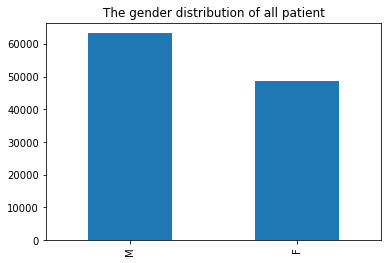

In [4]:
#gender distribution of all patient
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('The gender distribution of all patient')

In [5]:
len(all_xray_df[all_xray_df['Patient Gender']=='M'])/len(all_xray_df['Patient Gender'])

0.5649304316803425

In [6]:
len(all_xray_df[all_xray_df['Patient Gender']=='F'])/len(all_xray_df['Patient Gender'])

0.4350695683196575

Text(0.5, 1.0, 'The gender distribution of patient with pneuminia')

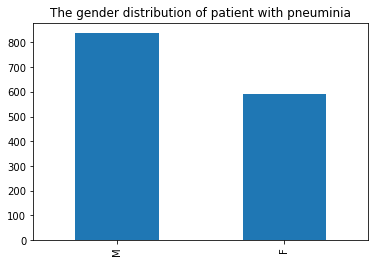

In [7]:
# gender distribution of patient with pneuminia
all_xray_df[all_xray_df['Pneumonia']==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('The gender distribution of patient with pneuminia')

## 1.2 Age Distribution

Text(0, 0.5, 'The number of patient')

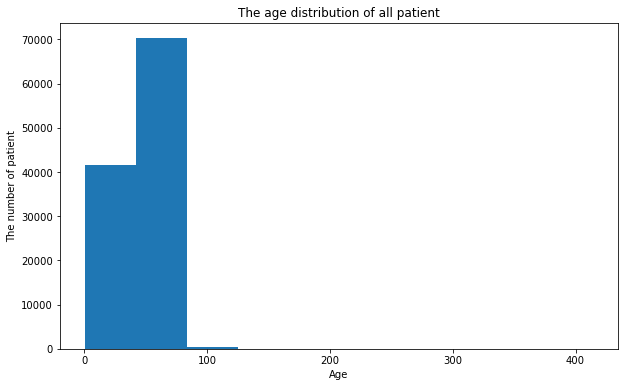

In [8]:
# age distribution of all patient
plt.figure(figsize=(10,6))
age = plt.hist(all_xray_df['Patient Age'])
plt.title('The age distribution of all patient')
plt.xlabel('Age')
plt.ylabel('The number of patient')

It can be seen that there are patients with age more than 120 years old, which is obviously wrong. So below we only focus on the data under the age of 100.

Text(0, 0.5, 'The number of patient')

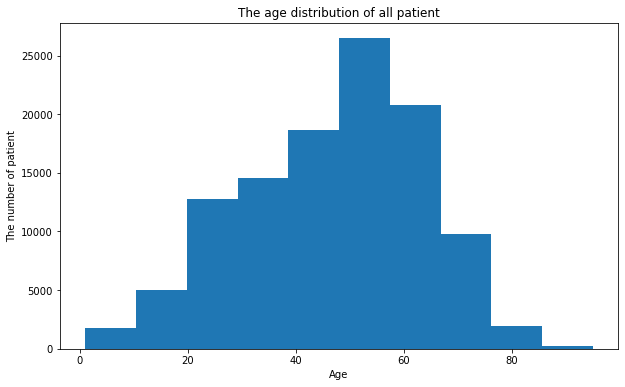

In [9]:
# age distribution of all patient
plt.figure(figsize=(10,6))
age = plt.hist(all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'])
plt.title('The age distribution of all patient')
plt.xlabel('Age')
plt.ylabel('The number of patient')

Text(0, 0.5, 'The number of patient')

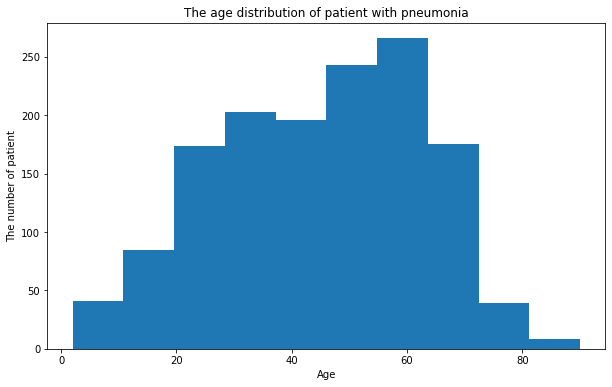

In [10]:
# age distribution of patient with pneumonia
plt.figure(figsize=(10,6))
age = plt.hist(all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'][all_xray_df['Pneumonia']==1])
plt.title('The age distribution of patient with pneumonia')
plt.xlabel('Age')
plt.ylabel('The number of patient')

In [11]:
age = all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'].to_list()

In [12]:
min(age)

1

In [13]:
max(age)

95

## 1.3 View Position Distribution

Text(0.5, 1.0, 'The view position distribution of all patient')

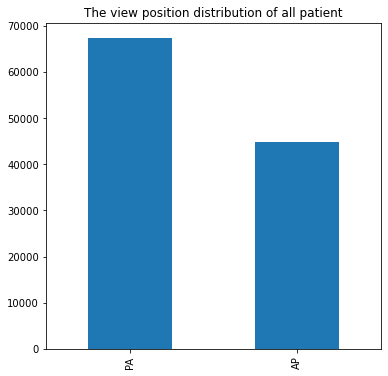

In [14]:
#View Position of all patient
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('The view position distribution of all patient') 

Text(0.5, 1.0, 'The view position distribution of patient with pneumonia')

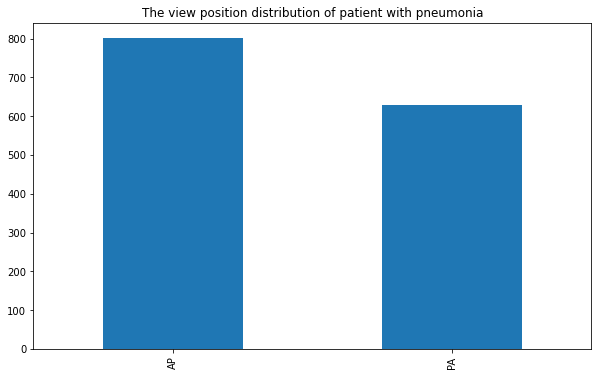

In [15]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df['Pneumonia']==1]['View Position'].value_counts().plot(kind='bar')
plt.title('The view position distribution of patient with pneumonia') 

## 1.4 Number of pneumonia cases

In [16]:
#number of pneumonia cases
all_xray_df['Pneumonia'].sum()

1431.0

In [17]:
all_xray_df[all_xray_df['Pneumonia']==1].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
73249,00018032_000.png,Infiltration|Nodule|Pneumonia,0,18032,17,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6032,00001629_006.png,Effusion|Pneumonia,6,1629,30,M,PA,2778,2937,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
78157,00019176_067.png,Edema|Infiltration|Pneumonia,67,19176,66,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 1.5 Number of non-pneumonia cases

In [18]:
# number of non-pneumonia cases
len(all_xray_df[all_xray_df['Pneumonia']==0])

110689

In [19]:
all_xray_df[all_xray_df['Pneumonia']==0].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1863,00000489_004.png,Consolidation|Infiltration,4,489,43,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
47638,00012087_050.png,No Finding,50,12087,68,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29552,00007685_000.png,No Finding,0,7685,23,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 1.6 The number of label=1 for each disease

[Text(0, 0.5, 'Number of Images with Label')]

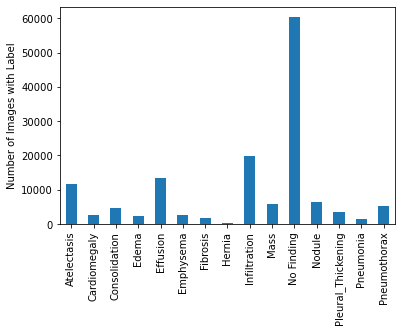

In [20]:
#the numer of label=1 for each disease
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')


## 1.7 The distribution of other diseases that are comorbid with pneumonia

Text(0.5, 1.0, 'The distribution of other diseases that are comorbid with pneumonia')

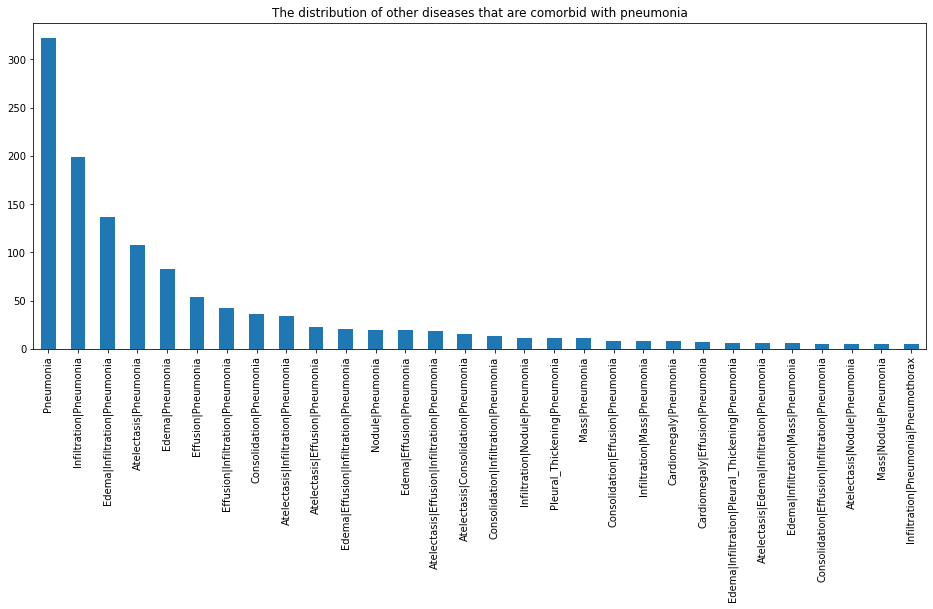

In [21]:
# The distribution of other diseases that are comorbid with pneumonia
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.title('The distribution of other diseases that are comorbid with pneumonia')

## 1.8 Number of disease per patient

In [22]:
# Number of disease per patient
all_labels.remove('No Finding')
Nod=0
for i in all_labels:
    Nod = Nod + all_xray_df[i]
all_xray_df['Number of disease'] = Nod


In [23]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of disease
98193,00025925_003.png,No Finding,3,25925,40,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22342,00005925_000.png,No Finding,0,5925,42,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18389,00004893_043.png,Atelectasis,43,4893,31,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Number of disease per patient(all dataset)')

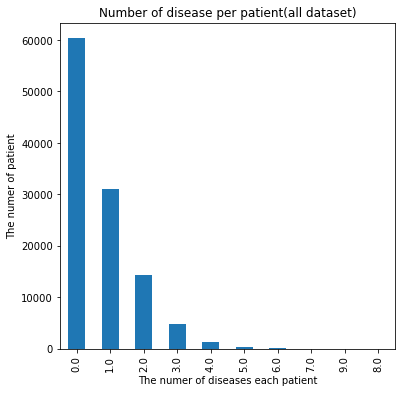

In [24]:
plt.figure(figsize=(6,6))
all_xray_df['Number of disease'].value_counts().plot(kind='bar')
plt.xlabel('The numer of diseases each patient')
plt.ylabel('The numer of patient')
plt.title('Number of disease per patient(all dataset)')

Text(0.5, 1.0, 'Number of disease per patient(with pneumonia)')

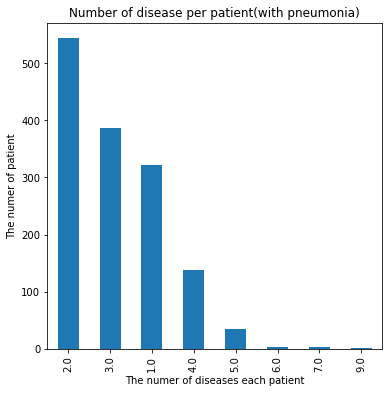

In [25]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Number of disease'].value_counts().plot(kind='bar')
plt.xlabel('The numer of diseases each patient')
plt.ylabel('The numer of patient')
plt.title('Number of disease per patient(with pneumonia)')

# 2 Pixel-level Analysis

In [26]:
# divide labels from Finding Labels
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5457,00029697_000.png,No Finding,0,29697,067Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4335,00021362_005.png,Effusion|Infiltration|Nodule|Pneumothorax,5,21362,058Y,F,PA,2706,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5322,00028682_004.png,No Finding,4,28682,055Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
sample_df[sample_df['Finding Labels']=='Pneumonia'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4583,00022877_014.png,Pneumonia,14,22877,056Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5366,00028924_005.png,Pneumonia,5,28924,072Y,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
!ls /data/images_001

images


In [29]:
# create image path and map it as a column to csv
paths = {os.path.basename(x): x for x in glob(os.path.join('/data/','images*/','images/','*.png'))}
sample_df['Image Path'] = sample_df['Image Index'].map(paths.get)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Image Path
3773,00018521_011.png,Effusion,11,18521,062Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_009/images/00018521_011.png
2561,00012874_002.png,Infiltration,2,12874,061Y,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_006/images/00012874_002.png
2361,00011966_022.png,No Finding,22,11966,022Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_006/images/00011966_022.png


In [30]:
#normalize the intensity of image

def norm_intensity(img):
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img-mean_intensity)/std_intensity
    return new_img

    

In [31]:
# plot the chest Xray images and corresponding intensity

def plot_imgs(img_path, rows, columns):
    ind= 1
    for img_p in img_path:
        img = io.imread(img_p)
        plt.subplot(rows, columns, ind)
        plt.imshow(img, cmap='gray')
        plt.title(sample_df[sample_df['Image Path']==img_p]['Finding Labels'].to_list()[0])
        intensity = norm_intensity(img)
        plt.subplot(rows, columns, ind+columns)
        plt.hist(intensity.ravel(), bins = 256)
        ind+=1

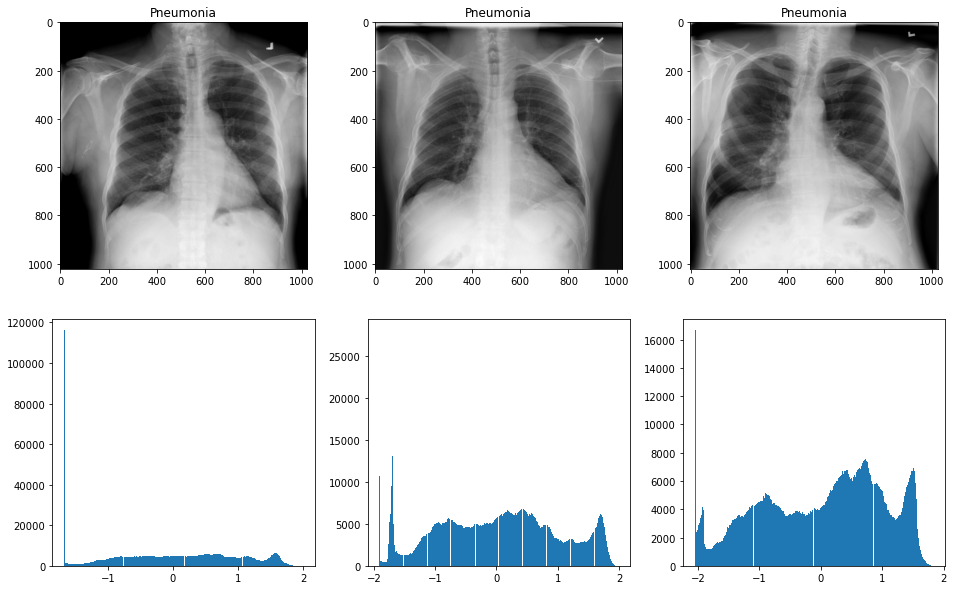

In [32]:
# select 3 image paths with label 'pneumonia' randomly
imgs_p = sample_df[sample_df['Finding Labels']=='Pneumonia']['Image Path'].sample(3)


# medical images with label Pneumonia and the corresponding histogramm of intensity values
plt.figure(figsize=(16,10))
plot_imgs(imgs_p, 2, 3)

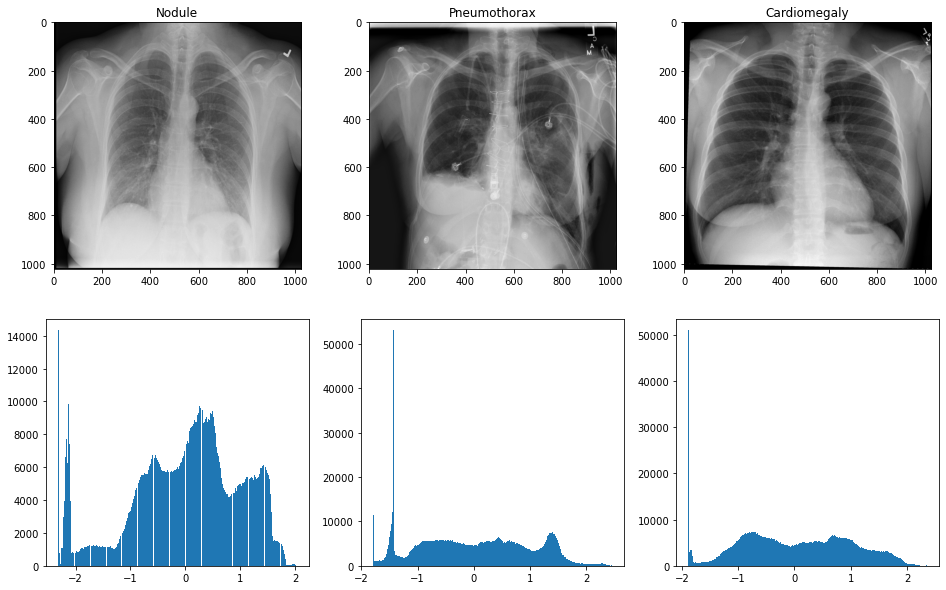

In [33]:
# select 3 image paths without label 'pneumonia' randomly
imgs_np = sample_df[sample_df['Pneumonia']==0]['Image Path'].sample(3)

# medical images without label Pneumonia and the corresponding histogramm of intensity values
plt.figure(figsize=(16,10))
plot_imgs(imgs_np, 2, 3)

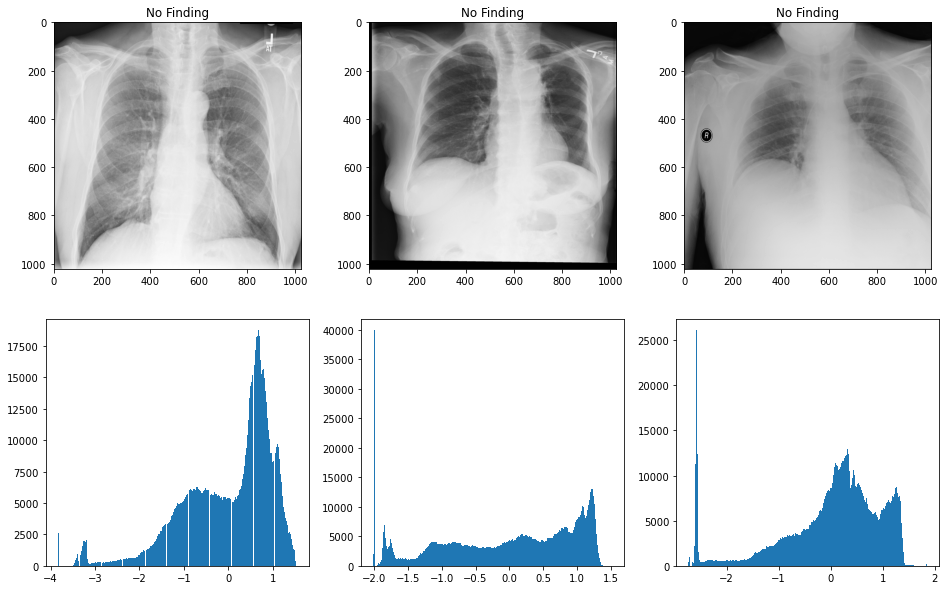

In [34]:
# select 3 image paths without label 'pneumonia' randomly
imgs_NF = sample_df[sample_df['Finding Labels']=='No Finding']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_NF, 2, 3)

## According to the distribution of other diseases that are comorbid with pneumonia. Medical images and their corresbonding intensity histogramms are arranged as below in order.

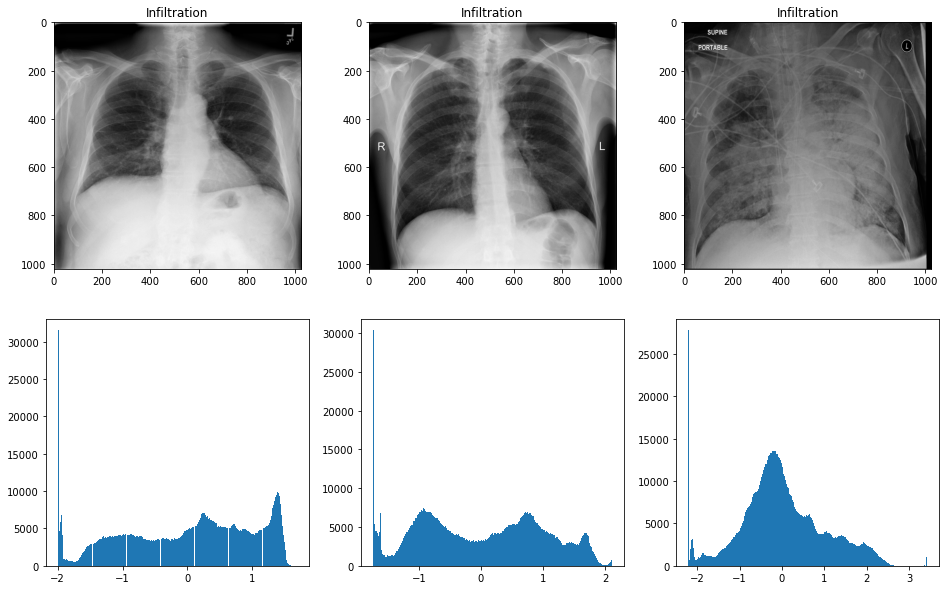

In [35]:
# select 3 image paths with label 'Infiltration' randomly
imgs_Inf = sample_df[sample_df['Finding Labels']=='Infiltration']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Inf, 2, 3)


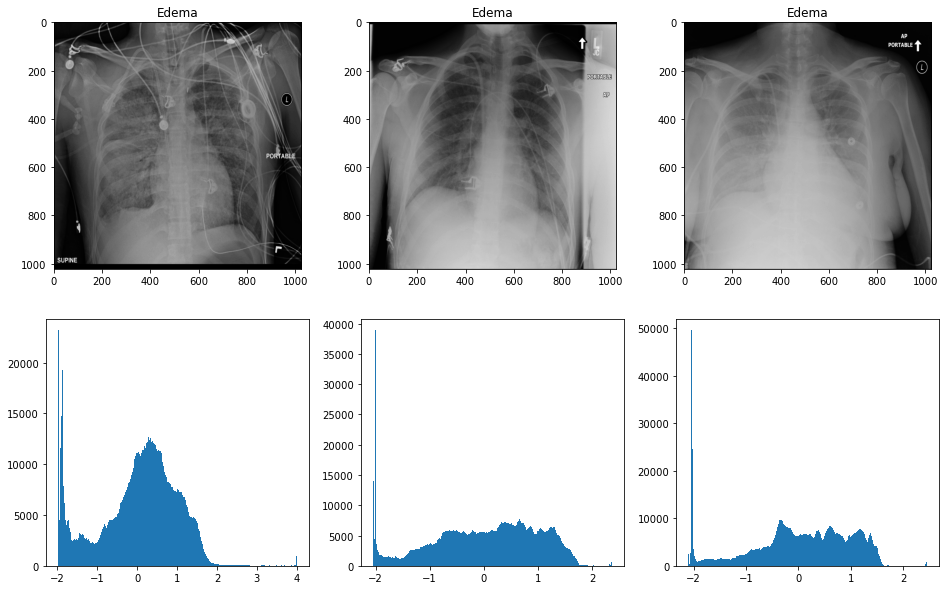

In [36]:
# select 3 image paths with label 'Edema' randomly
imgs_Edema = sample_df[sample_df['Finding Labels']=='Edema']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Edema, 2, 3)

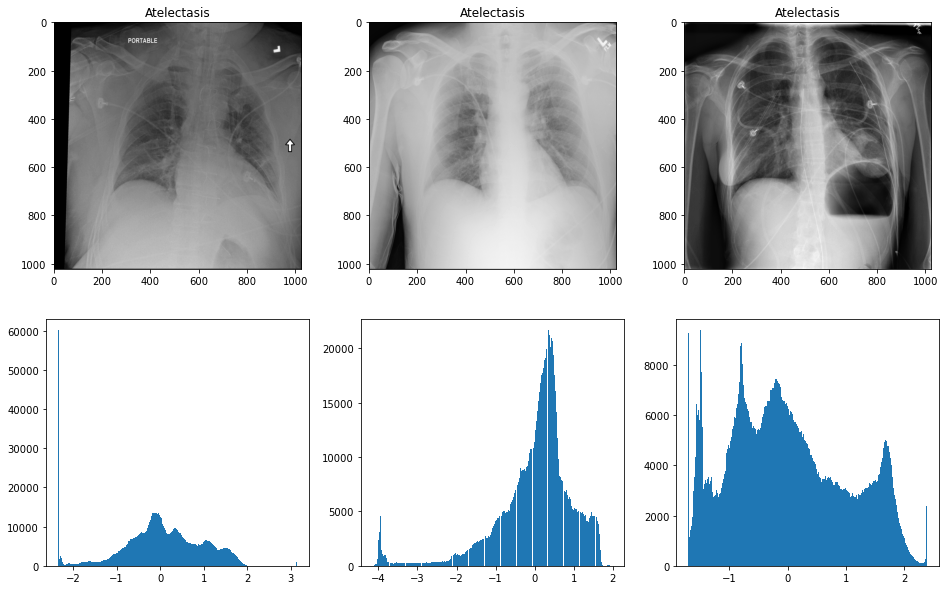

In [37]:
# select 3 image paths with label 'Atelectasis' randomly
imgs_Atel = sample_df[sample_df['Finding Labels']=='Atelectasis']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Atel, 2, 3)

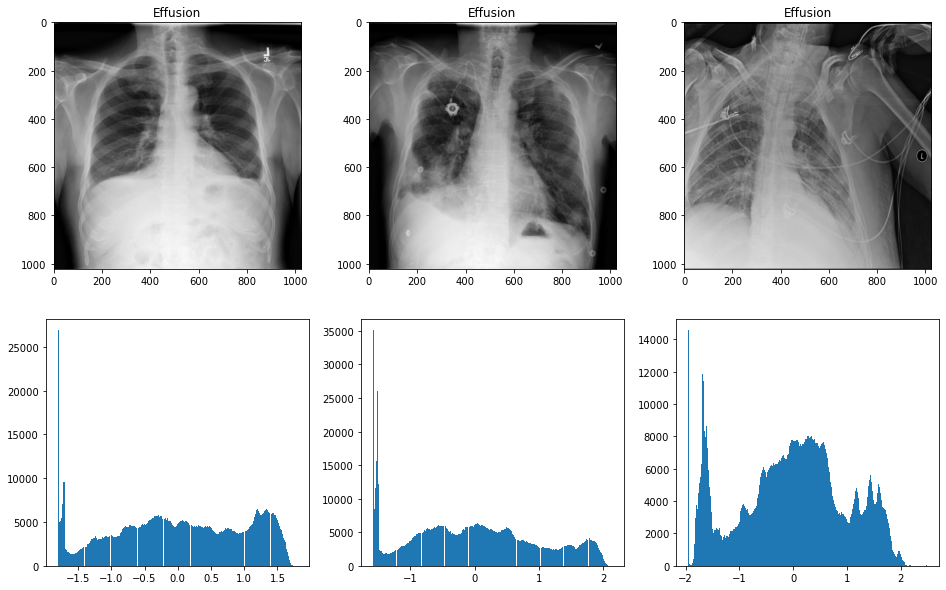

In [38]:
# select 3 image paths with label 'Effusion' randomly
imgs_Eff = sample_df[sample_df['Finding Labels']=='Effusion']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Eff, 2, 3)

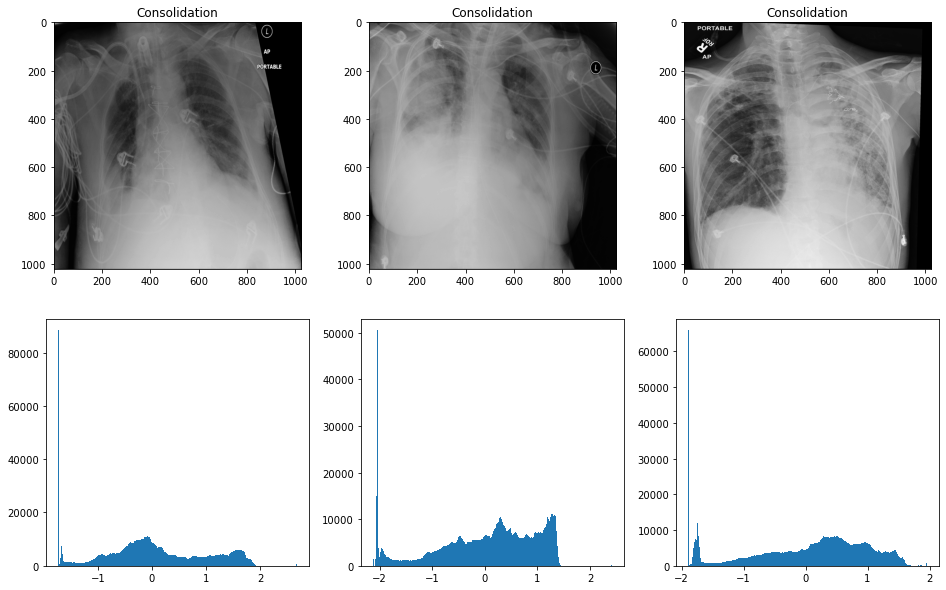

In [39]:
# select 3 image paths with label 'Consolidation' randomly
imgs_Cons = sample_df[sample_df['Finding Labels']=='Consolidation']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Cons, 2, 3)

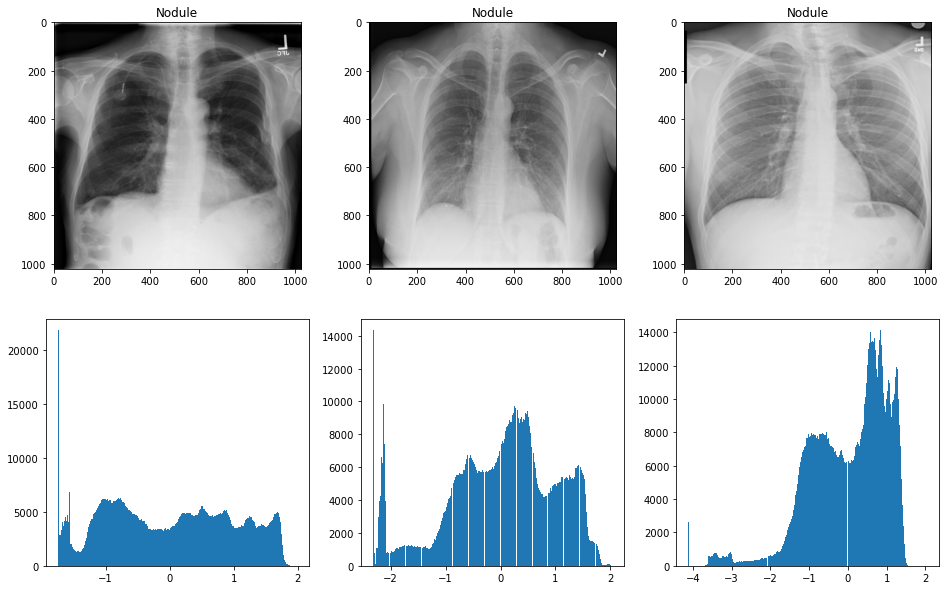

In [40]:
# select 3 image paths with label 'Nodule' randomly
imgs_Nodule = sample_df[sample_df['Finding Labels']=='Nodule']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Nodule, 2, 3)

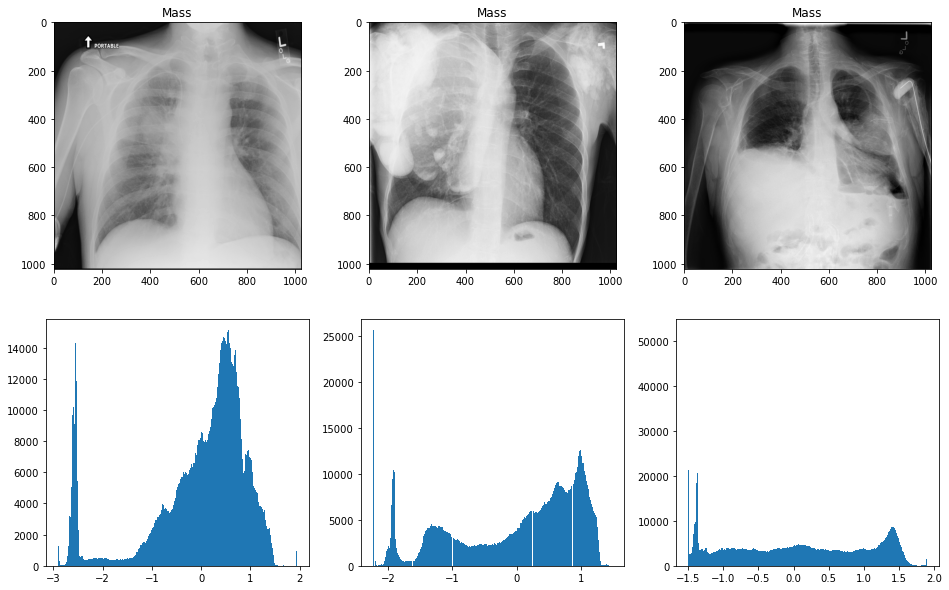

In [41]:
# select 3 image paths with label 'Mass' randomly
imgs_Mass = sample_df[sample_df['Finding Labels']=='Mass']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Mass, 2, 3)

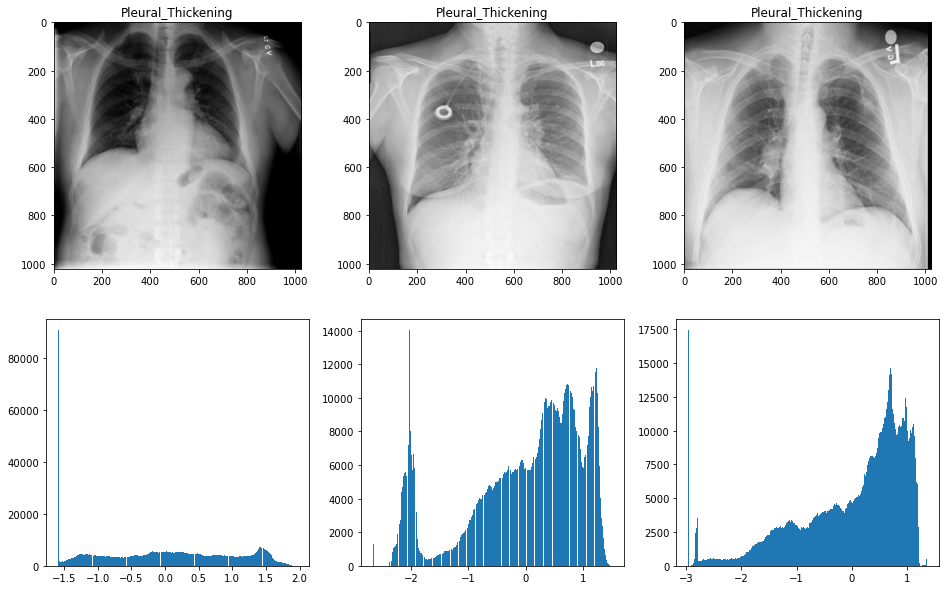

In [42]:
# select 3 image paths with label 'Pleural_Thickening' randomly
imgs_PlT = sample_df[sample_df['Finding Labels']=='Pleural_Thickening']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_PlT, 2, 3)

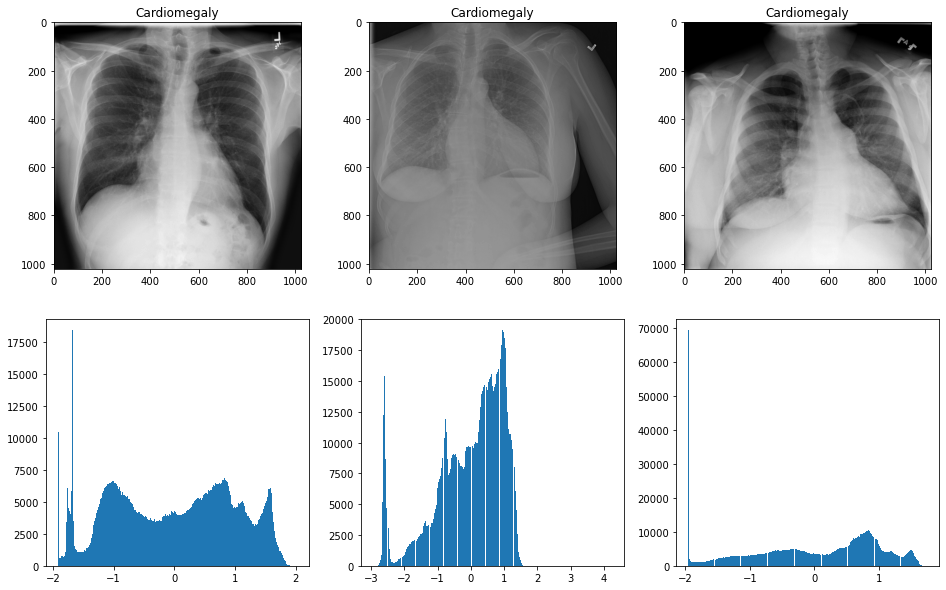

In [43]:
# select 3 image paths with label 'Cardiomegaly' randomly
imgs_Cad = sample_df[sample_df['Finding Labels']=='Cardiomegaly']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Cad, 2, 3)

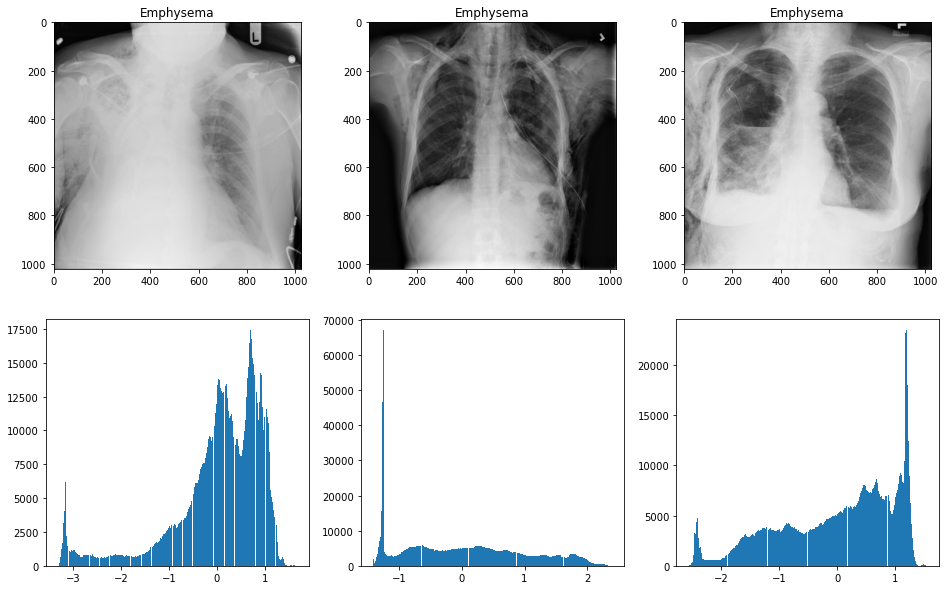

In [44]:
# select 3 image paths with label 'Emphysema' randomly
imgs_Emphy = sample_df[sample_df['Finding Labels']=='Emphysema']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Emphy, 2, 3)

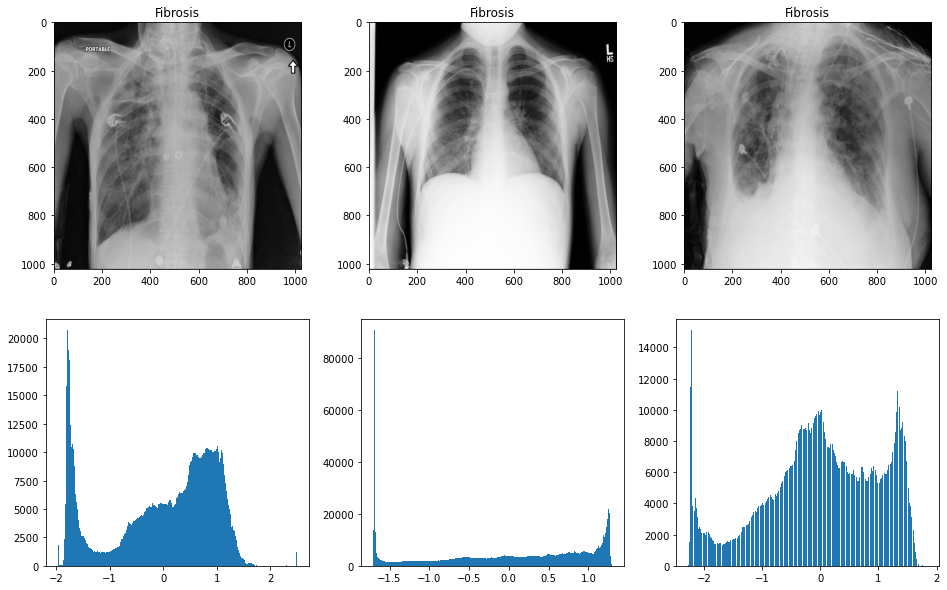

In [45]:
# select 3 image paths with label 'Fibrosis' randomly
imgs_Fibrosis = sample_df[sample_df['Finding Labels']=='Fibrosis']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Fibrosis, 2, 3)

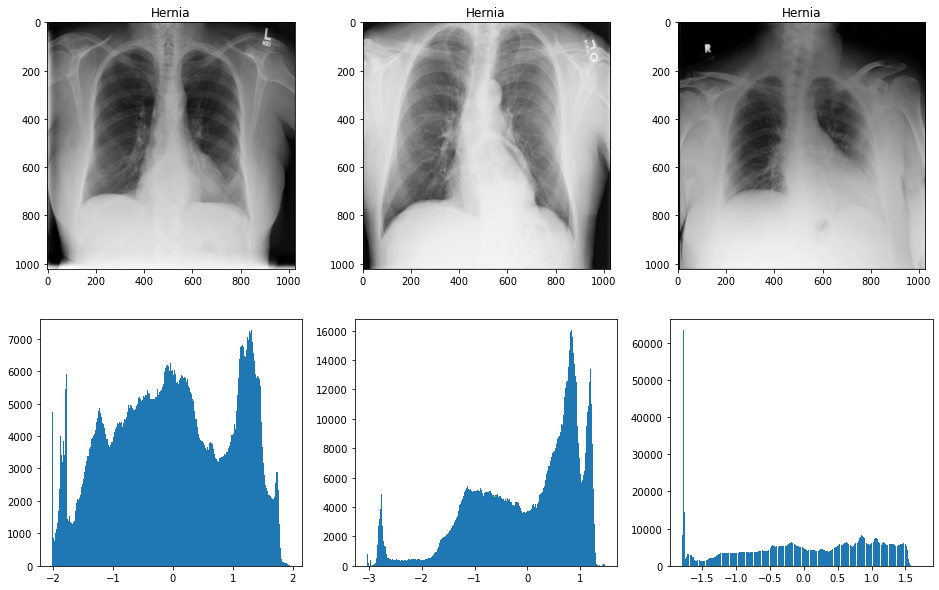

In [46]:
# select 3 image paths with label 'Hernia' randomly
imgs_Hernia = sample_df[sample_df['Finding Labels']=='Hernia']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Hernia, 2, 3)

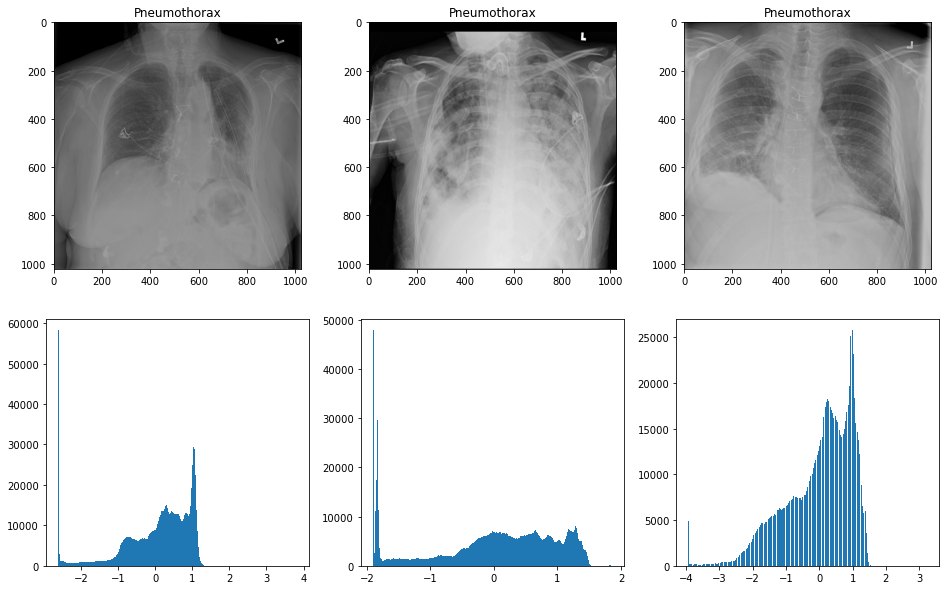

In [47]:
# select 3 image paths with label 'Pneumothorax' randomly
imgs_Pneumothorax = sample_df[sample_df['Finding Labels']=='Pneumothorax']['Image Path'].sample(3)
plt.figure(figsize=(16,10))
plot_imgs(imgs_Pneumothorax, 2, 3)

## Summary
### 1.1 Gender distribution:

- The model is based on both male and female patient. Because the proportion of male patients(0.56) in all patients is almost the same as the proportion of female(0.44). This distribution is also no difference for patients with pneumonia.

### 1.2 Age distribution

   - It can be seen that there are patients with age more than 120 years old, which is obviously wrong. So that we can only focus on the data under the age of 100. The diagram of age distribution of all data is similar as the data with pneumonia.

- As the diagram of age distribution with pneumonia showed, this model is trained on patients with age between 1 and 95.

### 1.3 View Position Distribution

   - All data is based on AP and PA. So it must be considered during this whole project.

### 1.4 Number of pneumonia cases % 1.5 Number of non-pneumonia cases

   - It's obviously that the number of patients with pneumonia is much less than the number of patients without pneumonia. This will leads to a huge imbalance for our training data. So an operation with downsampling is needed.

### 1.6 The number of label=1 for each disease &1.7 The distribution of other diseases that are comorbid with pneumonia

   - From 1.6 it can be seen that except label with 'No Finding' the label with 'Infiltration' appears at most. And it followed by 'Atelectasis' . 
   
   - The diagram from 1.7 showed that 'Infiltration' appears most often together with 'Pneumonia' , which followed by 'Edema' and 'Atelectasis'. 
   
   - These diseases might have impact on our model.

### 2 Pixel-Level analysis

   - The intensity diagram of pneumonia is similar as the diagram of  infiltration, effusion and consolidation. These  is a potential limitation of this algorithm.